# Classification and Scoring analysis for SDET Engineering position

---

We'll define the model to train a resume classifier for **SDET** position.

First, a data set for training will be defined in this same repository. The training data consists in several data engineering job descriptions found through different job search platforms.

---
## 1. Data Preparation

---
#### 1.1 Helper Function Definitions

In [1]:
import spacy

nlp = spacy.load('en_core_web_md')
position = 'sdet'


# Some helper functions
def clean_text(text, lemma=False):
    # Tokenize
    doc = nlp(text)
    
    # Remove Stopwords
    tokens = [token for token in doc if not (token.is_stop or token.is_punct) ]
    
    # Lemmatisation
    if lemma == True:
        tokens = [token.lemma_.strip().lower()  for token in tokens if token.lemma_.strip()]
    else:
        tokens = [token.text.strip().lower() for token in tokens if token.text.strip()]
    
    return ' '.join(tokens)

def get_metrics(df):

    DE_TP = df[(df['predicted'] == df[position]) & (df['predicted'] == 1)]
    DE_TN = df[(df['predicted'] == df[position]) & (df['predicted'] == 0)]
    DE_FP = df[(df['predicted'] != df[position]) & (df['predicted'] == 1)]
    DE_FN = df[(df['predicted'] != df[position]) & (df['predicted'] == 0)]
    
    print(f'TP: {len(DE_TP)} TN: {len(DE_TN)} FP: {len(DE_FP)} FN: {len(DE_FN)}')
    accuracy = (len(DE_TP)+len(DE_TN)) / len(df)
    precision = len(DE_TP)/((len(DE_TP)+len(DE_FP)) if (len(DE_TP)+len(DE_FP)) > 0 else 1)
    recall = len(DE_TP)/(len(DE_TP)+len(DE_FN))
    f1 = 2*(precision*recall)/((precision+recall) if precision+recall > 0 else 1)
    
    
    return accuracy, precision, recall, f1


def test_real_resumes(model ,models):
    import os

    # Loading and preparing real Resumes data
    candidates_df = pd.read_csv(os.path.join(testing_files_dir, 'candidates.csv'))
    candidates_df = candidates_df.dropna()
    candidates_df.rename(columns={'data_engineer':'data_engineering'}, inplace=True)
    candidates_df = candidates_df[candidates_df[['data_engineering', 'frontend', 'sdet']].any(axis=1)]

    # Predicting for real Resumes
    candidates_df['predicted'] = models[model].predict(candidates_df['text'])
    candidates_df['predicted_probs'] = tuple(models[model].predict_proba(candidates_df['text']))

    # Taking out resumes with no specific real classification (for now)
    print('Metrics for [', position, '] using model: [', model, ']\n')
    # Calculate metrics
    accuracy, precision, recall, f1 = get_metrics(candidates_df)
    
    print(f'Accuracy: {accuracy}\nPrecision: {precision}\nRecall: {recall}\nF1-score: {f1}')
    
    return candidates_df


def compare_models(models):
    # Loading and preparing real Resumes data
    candidates_df = pd.read_csv(os.path.join(testing_files_dir, 'candidates.csv'))
    candidates_df = candidates_df.dropna()
    candidates_df.rename(columns={'data_engineer':'data_engineering'}, inplace=True)
    candidates_df = candidates_df[candidates_df[['data_engineering', 'frontend', 'sdet']].any(axis=1)]
    
    predictions = pd.DataFrame()
    predictions['metrics'] = ['accuracy', 'precision', 'recall', 'f1-score']
    predictions = predictions.set_index('metrics')
    for name, model in models.items():
        temp = candidates_df.copy()
        temp['predicted'] = model.predict(candidates_df['text'])
        temp['predicted_probs'] = tuple(model.predict_proba(candidates_df['text']))
        
        accuracy, precision, recall, f1 = get_metrics(temp)
        predictions[name] = [accuracy, precision, recall, f1]
    
    return predictions

---
#### 1.2 Data Load and Preprocessing

In [2]:
import pandas as pd
import os

# Defining the directories to use
training_files_dir = './training_data'
testing_files_dir = './data/testing'
training_file = position + '.csv'

valid_formats = ['txt', 'doc', 'docx', 'rtf', 'pdf']

# Loading the file containing the training info
df = pd.read_csv(os.path.join(training_files_dir, training_file))
print('Cleaning null registries...')
df.isna().sum()
print('Cleaning text for each registry...')
df['corpus'] = df['description'].apply(lambda x: clean_text(x,lemma=True))

Cleaning null registries...
Cleaning text for each registry...


---
#### 1.3 Datasets Preparation

In [3]:
from sklearn.model_selection import train_test_split

# Separating training and test data
y = df['tag'].values

df_train, df_test = train_test_split(df, test_size=0.25, random_state=1000)

y_train = df_train['tag']
y_test = df_test['tag']

---
#### 1.4 Vectorizer

Text(0.5, 1.0, 'Sparse Matrix Sample')

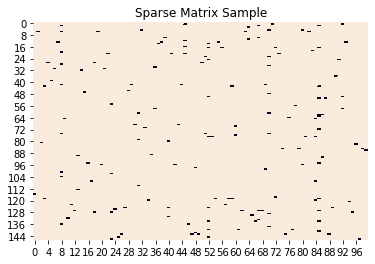

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import numpy as np


corpus = df_train['corpus']
# BoW
vectorizer = CountVectorizer(ngram_range=(1,2))
# TD-IDF
#vectorizer = TfidfVectorizer(ngram_range=(1,2))

vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)

sns.heatmap(X_train.todense()[:,np.random.randint(0,X_train.shape[1],100)]==0, vmin=0, vmax=1, cbar=False).set_title('Sparse Matrix Sample')

---
## 2. Models Analysis
---
#### 2.1 Logistic Regression Training

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

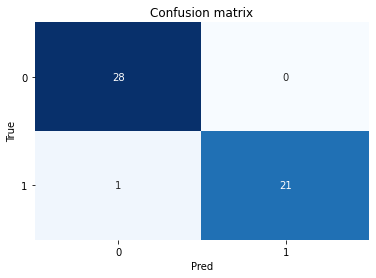

In [5]:
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import pipeline, preprocessing
from sklearn import metrics


models = {}

classifier = LogisticRegression()
model = pipeline.Pipeline([('vectorizer', vectorizer),
                            ('classifier', classifier)])
    
model['classifier'].fit(X_train, y_train)
models['LogisticRegression'] = model

X_test = df_test['corpus'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, [probs[1] for probs in predicted_prob])
cm = metrics.confusion_matrix(y_test, predicted)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

---
#### 2.2 SGDClassifier Training

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

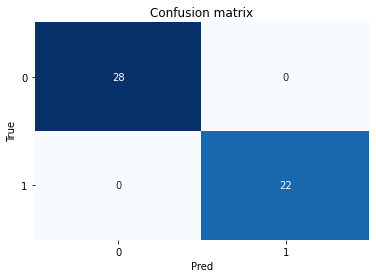

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV 


classifier = SGDClassifier()
classifier = classifier.fit(X_train, y_train)
calibrator = CalibratedClassifierCV(classifier, cv='prefit')

model = pipeline.Pipeline([('vectorizer', vectorizer),
                            ('classifier', calibrator)])
    
model['classifier'].fit(X_train, y_train)
models['SGDClassifier'] = model

X_test = df_test['corpus'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, [probs[1] for probs in predicted_prob])
cm = metrics.confusion_matrix(y_test, predicted)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

---
#### 2.3 SVC Training

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

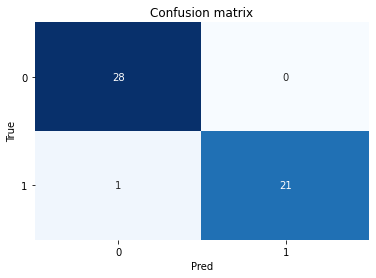

In [7]:
from sklearn.svm import SVC


classifier = SVC(probability=True)
model = pipeline.Pipeline([('vectorizer', vectorizer),
                            ('classifier', classifier)])
    
model['classifier'].fit(X_train, y_train)
models['SVC'] = model
    
X_test = df_test['corpus'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)

accuracy = metrics.accuracy_score(y_test, predicted)
auc = metrics.roc_auc_score(y_test, [probs[1] for probs in predicted_prob])
cm = metrics.confusion_matrix(y_test, predicted)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

---
#### 2.4 Naive Bayes

(array([0.5, 1.5]), [Text(0, 0.5, '0'), Text(0, 1.5, '1')])

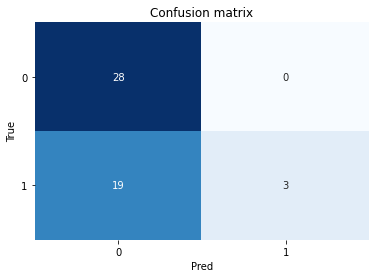

In [8]:
from sklearn import naive_bayes, pipeline, manifold, preprocessing

from sklearn import metrics
import matplotlib.pyplot as plt

classifier = naive_bayes.BernoulliNB()
model = pipeline.Pipeline([('vectorizer', vectorizer),
                           ('classifier', classifier)])

model['classifier'].fit(X_train, y_train)
models['NaiveBayes'] = model

X_test = df_test['corpus'].values
predicted = model.predict(X_test)
predicted_prob = model.predict_proba(X_test)


accuracy = metrics.accuracy_score(y_test.values, predicted)
auc = metrics.roc_auc_score(y_test.values, [probs[1] for probs in predicted_prob])
cm = metrics.confusion_matrix(y_test, predicted)
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values

fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

---
#### 2.5 Comparing Metrics with Real Resumes

In [9]:
df = test_real_resumes('LogisticRegression', models)
df[df[position] == 1]

Metrics for [ sdet ] using model: [ LogisticRegression ]

TP: 10 TN: 50 FP: 1 FN: 2
Accuracy: 0.9523809523809523
Precision: 0.9090909090909091
Recall: 0.8333333333333334
F1-score: 0.8695652173913043


,name,data_engineering,frontend,sdet,text,predicted,predicted_probs
5,DianaPatronGalindo,1,0,1,diana patron galindo patrondiana13@hotmail.com...,1,"(0.36949045000615066, 0.6305095499938493)"
8,Alan_Trevino,0,1,1,alan treviño geek article reader open source l...,1,"(0.001974181255475993, 0.998025818744524)"
19,Cesar_Recio_Monroy,0,0,1,2017­6­14 detalle cv laura plata 10 tae usa in...,1,"(4.076536963548705e-08, 0.9999999592346304)"
30,Elohim_A_Falcón_Avilez,0,1,1,elohim falcón contact email website elohimalon...,1,"(0.44843804920097874, 0.5515619507990213)"
39,Heber_Barba,0,1,1,senior software engineer heber barba cv 458202...,1,"(0.09630488655982627, 0.9036951134401737)"
50,Jesus_Eduardo_Burquez_Reynaga,0,0,1,jesús armando montalvo urbina ingeniero en mec...,0,"(0.9930030518557089, 0.00699694814429105)"
58,Julio_Iran_Montaño_Rojas,0,0,1,test automation engineer julio iran montaño ro...,1,"(1.3465450976468674e-11, 0.9999999999865345)"
69,Miguel_Angel_Davila_Galavis,0,0,1,software engineer qa testing lead miguel angel...,1,"(0.0029591730017143325, 0.9970408269982857)"
72,Milton_Mauricio_Orta_Negrete,0,0,1,312017 currículo oficina de soporte en línea r...,1,"(0.007779187282823008, 0.992220812717177)"
77,René_Sosa,0,0,1,rené sosa sr software test engineer qc analyst...,1,"(4.440892098500626e-16, 0.9999999999999996)"


In [10]:
df = test_real_resumes('SGDClassifier', models)
df[df[position] == 1]

Metrics for [ sdet ] using model: [ SGDClassifier ]

TP: 9 TN: 48 FP: 3 FN: 3
Accuracy: 0.9047619047619048
Precision: 0.75
Recall: 0.75
F1-score: 0.75


,name,data_engineering,frontend,sdet,text,predicted,predicted_probs
5,DianaPatronGalindo,1,0,1,diana patron galindo patrondiana13@hotmail.com...,1,"(0.2854082748580611, 0.7145917251419389)"
8,Alan_Trevino,0,1,1,alan treviño geek article reader open source l...,1,"(0.007455428871326664, 0.9925445711286733)"
19,Cesar_Recio_Monroy,0,0,1,2017­6­14 detalle cv laura plata 10 tae usa in...,1,"(3.0271581419438753e-05, 0.9999697284185806)"
30,Elohim_A_Falcón_Avilez,0,1,1,elohim falcón contact email website elohimalon...,0,"(0.8092782293894822, 0.1907217706105178)"
39,Heber_Barba,0,1,1,senior software engineer heber barba cv 458202...,1,"(0.08012213195665996, 0.91987786804334)"
50,Jesus_Eduardo_Burquez_Reynaga,0,0,1,jesús armando montalvo urbina ingeniero en mec...,0,"(0.819852046006973, 0.18014795399302697)"
58,Julio_Iran_Montaño_Rojas,0,0,1,test automation engineer julio iran montaño ro...,1,"(5.1745070006603555e-08, 0.99999994825493)"
69,Miguel_Angel_Davila_Galavis,0,0,1,software engineer qa testing lead miguel angel...,1,"(0.0021628692968947982, 0.9978371307031052)"
72,Milton_Mauricio_Orta_Negrete,0,0,1,312017 currículo oficina de soporte en línea r...,1,"(0.0021628692968947982, 0.9978371307031052)"
77,René_Sosa,0,0,1,rené sosa sr software test engineer qc analyst...,1,"(1.9976020837475517e-11, 0.999999999980024)"


In [11]:
df = test_real_resumes('SVC', models)
df[df[position] == 1]

Metrics for [ sdet ] using model: [ SVC ]

TP: 2 TN: 51 FP: 0 FN: 10
Accuracy: 0.8412698412698413
Precision: 1.0
Recall: 0.16666666666666666
F1-score: 0.2857142857142857


,name,data_engineering,frontend,sdet,text,predicted,predicted_probs
5,DianaPatronGalindo,1,0,1,diana patron galindo patrondiana13@hotmail.com...,0,"(0.28464083138731344, 0.7153591686126867)"
8,Alan_Trevino,0,1,1,alan treviño geek article reader open source l...,1,"(1.2919460746702346e-05, 0.9999870805392532)"
19,Cesar_Recio_Monroy,0,0,1,2017­6­14 detalle cv laura plata 10 tae usa in...,1,"(0.09318707680425138, 0.9068129231957485)"
30,Elohim_A_Falcón_Avilez,0,1,1,elohim falcón contact email website elohimalon...,0,"(0.3782157774835806, 0.6217842225164193)"
39,Heber_Barba,0,1,1,senior software engineer heber barba cv 458202...,0,"(0.30807231728019724, 0.6919276827198029)"
50,Jesus_Eduardo_Burquez_Reynaga,0,0,1,jesús armando montalvo urbina ingeniero en mec...,0,"(0.9732713467472314, 0.02672865325276852)"
58,Julio_Iran_Montaño_Rojas,0,0,1,test automation engineer julio iran montaño ro...,0,"(0.2693086531762251, 0.7306913468237749)"
69,Miguel_Angel_Davila_Galavis,0,0,1,software engineer qa testing lead miguel angel...,0,"(0.41385957506448073, 0.5861404249355192)"
72,Milton_Mauricio_Orta_Negrete,0,0,1,312017 currículo oficina de soporte en línea r...,0,"(0.41385958354850866, 0.5861404164514914)"
77,René_Sosa,0,0,1,rené sosa sr software test engineer qc analyst...,0,"(0.26481641597017985, 0.7351835840298203)"


In [12]:
df = test_real_resumes('NaiveBayes', models)
df[df[position] == 1]

Metrics for [ sdet ] using model: [ NaiveBayes ]

TP: 0 TN: 51 FP: 0 FN: 12
Accuracy: 0.8095238095238095
Precision: 0.0
Recall: 0.0
F1-score: 0.0


,name,data_engineering,frontend,sdet,text,predicted,predicted_probs
5,DianaPatronGalindo,1,0,1,diana patron galindo patrondiana13@hotmail.com...,0,"(1.0, 1.7857036338590655e-81)"
8,Alan_Trevino,0,1,1,alan treviño geek article reader open source l...,0,"(1.0, 1.2293479572420419e-74)"
19,Cesar_Recio_Monroy,0,0,1,2017­6­14 detalle cv laura plata 10 tae usa in...,0,"(1.0, 5.092360216506829e-59)"
30,Elohim_A_Falcón_Avilez,0,1,1,elohim falcón contact email website elohimalon...,0,"(1.0, 1.745754530109137e-90)"
39,Heber_Barba,0,1,1,senior software engineer heber barba cv 458202...,0,"(1.0, 9.030377252310402e-92)"
50,Jesus_Eduardo_Burquez_Reynaga,0,0,1,jesús armando montalvo urbina ingeniero en mec...,0,"(1.0, 3.2328634336932506e-123)"
58,Julio_Iran_Montaño_Rojas,0,0,1,test automation engineer julio iran montaño ro...,0,"(1.0, 5.618873498769248e-59)"
69,Miguel_Angel_Davila_Galavis,0,0,1,software engineer qa testing lead miguel angel...,0,"(1.0, 1.4298689941280767e-83)"
72,Milton_Mauricio_Orta_Negrete,0,0,1,312017 currículo oficina de soporte en línea r...,0,"(1.0, 3.616776832272899e-101)"
77,René_Sosa,0,0,1,rené sosa sr software test engineer qc analyst...,0,"(1.0, 9.352359747351517e-15)"


---
#### 2.6 Choosing the Model

In [13]:
compare_models(models)

TP: 10 TN: 50 FP: 1 FN: 2
TP: 9 TN: 48 FP: 3 FN: 3
TP: 2 TN: 51 FP: 0 FN: 10
TP: 0 TN: 51 FP: 0 FN: 12


,LogisticRegression,SGDClassifier,SVC,NaiveBayes
metrics,,,,
accuracy,0.952381,0.904762,0.841270,0.809524
precision,0.909091,0.750000,1.000000,0.000000
recall,0.833333,0.750000,0.166667,0.000000
f1-score,0.869565,0.750000,0.285714,0.000000


In [14]:
deploy_dir = '../app/models'
model_to_deploy = 'LogisticRegression'

pd.to_pickle(models[model_to_deploy], os.path.join(deploy_dir, '.'.join([position, 'pickle'])))